In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/cs664/hit_ball')

In [7]:
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam
from PIL import Image
import collections
import numpy as np
import os
import pygame
from keras import backend as K
import auto_game
import math
import random

In [4]:
# 将游戏截屏调整大小，归一化，并使其满足模型输入数据要求
def preprocess_images(image):
    # 图像大小调整为(80,80)，Image与numpy array互换时维度都会翻转
    # 如果宽度与高度不等时应特别注意
    x_t = np.array(Image.fromarray(image).resize((80, 80)))
    x_t = x_t.astype("float")
    x_t = (x_t - 50) / (213 - 50)  # 归一化
    # 形状调整为(1, 80, 80, 3)，以满足模型对输入数据的要求
    s_t = np.expand_dims(x_t, axis=0)
    return s_t

def get_next_batch(experience_positive, experience_negative, model, num_actions, gamma, batch_size):
    # 从经验池中随机选取一批数据
    batch_indices_1 = np.random.randint(low=0, high=len(experience_positive), size=int(batch_size/2))
    batch_indices_2 = np.random.randint(low=0, high=len(experience_negative), size=int(batch_size/2))
    batch_1 = [experience_positive[i] for i in batch_indices_1]
    batch_2 = [experience_negative[i] for i in batch_indices_2]
    batch = batch_1+batch_2
    # 训练数据初始化
    X = np.zeros((batch_size, 80, 80, 3))
    Y = np.zeros((batch_size, num_actions))
    # 给训练数据赋值
    for i in range(len(batch)):  # 第i个数据
        s_t, a_t, r_t, s_tp1, game_over = batch[i]
        X[i] = s_t  # 给第i个输入数据赋值
        Y[i] = a_t
    return X, Y

def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=8, strides=4,
                     kernel_initializer="normal",
                     padding="same",
                     input_shape=(80, 80, 3)))
    model.add(Activation("relu"))
    model.add(Conv2D(64, kernel_size=4, strides=2,
                     kernel_initializer="normal",
                     padding="same"))
    model.add(Activation("relu"))
    model.add(Conv2D(64, kernel_size=3, strides=1,
                     kernel_initializer="normal",
                     padding="same"))
    model.add(Activation("relu"))
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer="normal"))
    model.add(Activation("relu"))
    model.add(Dense(1, kernel_initializer="normal"))
    model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")
    return model

In [ ]:
# 定义常量，初始化变量
NUM_ACTIONS = 2  # 动作数量 (不动，向右移动)
GAMMA = 0.99  # 未来回报的折扣因子
INITIAL_EPSILON = 0.1  # epsilon的初值
FINAL_EPSILON = 0.0001  # epsilon的终值
epsilon = INITIAL_EPSILON
BATCH_SIZE = 64  # 批大小
num_wins = 0  # 初始化成绩
experience_negative = collections.deque(maxlen=1000)  # 经验池
experience_positive = collections.deque(maxlen=1000)  # 经验池
NUM_EPOCHS_OBSERVE = 200  # 观察轮数
NUM_EPOCHS_TRAIN = 500 # 训练轮数
NUM_EPOCHS = NUM_EPOCHS_OBSERVE + NUM_EPOCHS_TRAIN  # 总轮数
DATA_DIR = '/content/drive/MyDrive/cs664/hit_ball/data'
MODEL_PATH = os.path.join(DATA_DIR, "ball_hit_ball_model_t5.keras")
TRAIN_LOG_PATH = os.path.join(DATA_DIR, "train_log_1.txt")

# 搭建和配置模型
model = get_model()
# 将模型保存到文件
model.save(MODEL_PATH, overwrite=True)
# 初始化游戏
game = auto_game.Ball_Hit_Ball_Game()

In [ ]:
for e in range(NUM_EPOCHS):
    K.clear_session()  # 清除会话，防止内存耗尽
    model = load_model(MODEL_PATH)  # 重新载入模型
    fout = open(TRAIN_LOG_PATH, "a+")  # 打开训练记录文件
    loss = 0.0  # 初始化损失
    game.reset()  # 重置游戏状态

    # 获取第一个截屏
    a_t = 0  # (0 = 不动, 1 = 右移动)
    x_t, r_0, game_over = game.step(a_t)
    # 对数据进行处理
    s_t = preprocess_images(x_t)

    while (a_t ==0) and (not game_over):
        s_tm1 = s_t  # 保存为t-1时刻的截屏
        # 确定一下个动作
        if e <= NUM_EPOCHS_OBSERVE:  # 观察期随机探索
            a_t = np.random.randint(2, size=1)[0]
        else:  # 观察期以后
            if np.random.rand() <= epsilon:  # 随机探索
                a_t = np.random.randint(2, size=1)[0]
            else:  # 根据模型决策
                q = model.predict(s_t)[0]
                a_t = int(q>0.5)
        x_t, r_t, game_over = game.step(a_t)  # 执行动作，获取反馈
        s_t = preprocess_images(x_t)  # 对数据进行处理
    screenshot = s_t
    while (a_t==1) and (not game_over):
        x_t, r_t, game_over = game.step(a_t)  # 执行动作，获取反馈
        s_t = preprocess_images(x_t)

    if r_t == 1:  # 如果篮球碰到红球，记录成功一次
        num_wins += 1
        experience_positive.append((screenshot, 1, r_t, s_t, game_over))
    if r_t == -1:
        # 将原状态、动作、回报、新状态和游戏是否结束等信息保存到经验池中
        experience_negative.append((screenshot, 0, r_t, s_t, game_over))

    if e > NUM_EPOCHS_OBSERVE:  # 观察期以后
        # 从经验集合中抽取一批数据
        X, Y = get_next_batch(experience_positive, experience_negative, model, NUM_ACTIONS, GAMMA, BATCH_SIZE)
        model.fit(X, Y,verbose=0)  # 训练模型，并记录损失
        loss += model.evaluate(X, Y)

    # 逐渐减小探索频率，增加利用频率
    if epsilon > FINAL_EPSILON:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / NUM_EPOCHS

    print('epoch=',e,'loss=',loss,'num_wins=',num_wins)

    # 保存训练数据
    fout.write("{:04d}\t{:.5f}\t{:d}\n".format(e + 1, loss, num_wins))
    fout.close()

    # 保存模型
    model.save(MODEL_PATH, overwrite=True)

epoch= 0 loss= 0.0 num_wins= 0
epoch= 1 loss= 0.0 num_wins= 0
epoch= 2 loss= 0.0 num_wins= 0
epoch= 3 loss= 0.0 num_wins= 0
epoch= 4 loss= 0.0 num_wins= 0
epoch= 5 loss= 0.0 num_wins= 0
epoch= 6 loss= 0.0 num_wins= 0
epoch= 7 loss= 0.0 num_wins= 0
epoch= 8 loss= 0.0 num_wins= 0
epoch= 9 loss= 0.0 num_wins= 0
epoch= 10 loss= 0.0 num_wins= 0
epoch= 11 loss= 0.0 num_wins= 0
epoch= 12 loss= 0.0 num_wins= 0
epoch= 13 loss= 0.0 num_wins= 0
epoch= 14 loss= 0.0 num_wins= 0
epoch= 15 loss= 0.0 num_wins= 0
epoch= 16 loss= 0.0 num_wins= 1
epoch= 17 loss= 0.0 num_wins= 1
epoch= 18 loss= 0.0 num_wins= 1
epoch= 19 loss= 0.0 num_wins= 1
epoch= 20 loss= 0.0 num_wins= 1
epoch= 21 loss= 0.0 num_wins= 1
epoch= 22 loss= 0.0 num_wins= 1
epoch= 23 loss= 0.0 num_wins= 1
epoch= 24 loss= 0.0 num_wins= 1
epoch= 25 loss= 0.0 num_wins= 1
epoch= 26 loss= 0.0 num_wins= 1
epoch= 27 loss= 0.0 num_wins= 1
epoch= 28 loss= 0.0 num_wins= 1
epoch= 29 loss= 0.0 num_wins= 1
epoch= 30 loss= 0.0 num_wins= 1
epoch= 31 loss= 0.

2/2 [==============================] - 0s 15ms/step - loss: 0.2364
epoch= 205 loss= 0.23639757931232452 num_wins= 23


2/2 [==============================] - 0s 14ms/step - loss: 0.2621
epoch= 206 loss= 0.2620907425880432 num_wins= 23
2/2 [==============================] - 0s 14ms/step - loss: 0.2483
epoch= 207 loss= 0.24825143814086914 num_wins= 23
2/2 [==============================] - 0s 11ms/step - loss: 0.2339
epoch= 208 loss= 0.2338881939649582 num_wins= 23
2/2 [==============================] - 0s 15ms/step - loss: 0.2268
epoch= 209 loss= 0.22681331634521484 num_wins= 23
2/2 [==============================] - 0s 13ms/step - loss: 0.2247
epoch= 210 loss= 0.22470887005329132 num_wins= 23
2/2 [==============================] - 0s 13ms/step - loss: 0.2078
epoch= 211 loss= 0.20777171850204468 num_wins= 24
2/2 [==============================] - 0s 15ms/step - loss: 0.2100
epoch= 212 loss= 0.2099526971578598 num_wins= 25
2/2 [==============================] - 0s 15ms/step - loss: 0.1947
epoch= 213 loss= 0.19471684098243713 num_wins= 25
2/2 [==============================] - 0s 14ms/step - loss: 0.1619


2/2 [==============================] - 0s 15ms/step - loss: 0.0255
epoch= 253 loss= 0.02549159713089466 num_wins= 31


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 13ms/step - loss: 0.0048
epoch= 475 loss= 0.004800833761692047 num_wins= 154
2/2 [==============================] - 0s 18ms/step - loss: 0.0023
epoch= 476 loss= 0.0023495915811508894 num_wins= 155
2/2 [==============================] - 0s 14ms/step - loss: 0.0022
epoch= 477 loss= 0.002215480199083686 num_wins= 155
2/2 [==============================] - 0s 13ms/step - loss: 0.0025
epoch= 478 loss= 0.0025261857081204653 num_wins= 156
2/2 [==============================] - 0s 14ms/step - loss: 0.0033
epoch= 479 loss= 0.0033214972354471684 num_wins= 156
2/2 [==============================] - 0s 19ms/step - loss: 8.4854e-04
epoch= 480 loss= 0.0008485373109579086 num_wins= 157
2/2 [==============================] - 0s 16ms/step - loss: 0.0031
epoch= 481 loss= 0.0030668750405311584 num_wins= 158
2/2 [==============================] - 0s 14ms/step - loss: 0.0017
epoch= 482 loss= 0.0016549387946724892 n

In [ ]:
batch_indices_1 = np.random.randint(low=0, high=len(experience_positive), size=int(BATCH_SIZE/2))
batch_indices_2 = np.random.randint(low=0, high=len(experience_negative), size=int(BATCH_SIZE/2))
batch_1 = [experience_positive[i] for i in batch_indices_1]
batch_2 = [experience_negative[i] for i in batch_indices_2]
batch = batch_1+batch_2

In [6]:
DATA_DIR = '/content/drive/MyDrive/cs664/hit_ball/data'
MODEL_PATH = os.path.join(DATA_DIR, "ball_hit_ball_model_t5.keras")
BATCH_SIZE = 32
NUM_EPOCHS = 100

# 载入模型，当模型在不同版本的keras下训练时，可将compile设置为False
model = load_model(MODEL_PATH, compile=False)
model.compile(optimizer=Adam(learning_rate=1e-6), loss="mse")

# 启动游戏
game = auto_game.Ball_Hit_Ball_Game()

# 初始化变量
num_games, num_wins = 0, 0

for e in range(NUM_EPOCHS):
    game.reset()
    flag=0
    a_t = 0  # 选择第一个动作
    x_0, r_0, game_over = game.step(a_t) # 执行第一个动作
    s_t = preprocess_images(x_0)    # 数据处理
    while (a_t ==0) and (not game_over):
        s_tm1 = s_t  # 保存为t-1时刻的截屏
        flag+=1


        q = model.predict(s_t,verbose=0)[0]
        a_t = int(q>0.5)
        x_t, r_t, game_over = game.step(a_t)  # 执行动作，获取反馈
        s_t = preprocess_images(x_t)  # 对数据进行处理
    print(flag)
    while (a_t==1) and (not game_over):
        x_t, r_t, game_over = game.step(a_t)  # 执行动作，获取反馈
        s_t = preprocess_images(x_t)

    if r_t == 1:  # 如果篮球碰到红球，记录成功一次
        num_wins += 1
    num_games += 1
pygame.quit() # 退出游戏
print("game number: {:03d}, successful number: {:03d}".format(num_games, num_wins))

28
27
21
31
19
1
26
31
29
27
1
31
25
17
32
31
21
1
20
28
21
18
21
22
32
32
24
31
21
24
1
24
19
1
23
30
25
29
20
1
32
29
27
32
29
32
30
32
1
23
1
1
24
24
18
31
31
1
1
18
32
24
29
19
1
19
18
30
22
1
28
28
23
31
1
27
29
24
21
20
24
27
21
1
29
1
23
23
32
28
18
28
21
1
25
22
28
1
23
24
game number: 100, successful number: 100


In [ ]:
model.predict(s_t)

1/1 [==============================] - 0s 161ms/step


array([[-0.00535004]], dtype=float32)

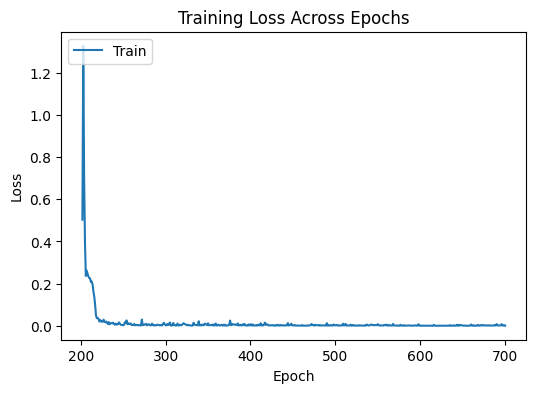

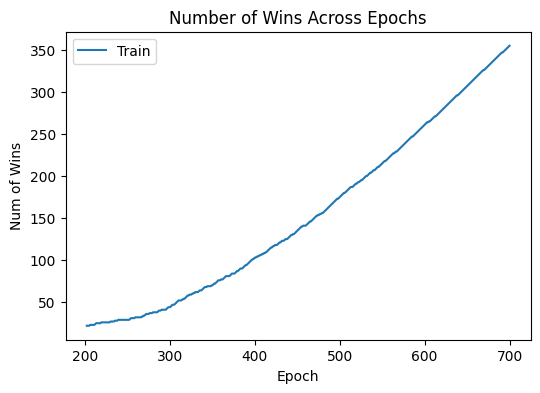

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取训练日志数据
with open(os.path.join(DATA_DIR, 'train_log.txt'), 'r', encoding='utf-8') as f:
    data = f.readlines()

# 创建DataFrame并解析数据
df = pd.DataFrame(data)
df['epoch'], df['loss'], df['num_wins'] = zip(*df[0].str.split('\t').tolist())
df['epoch'] = df['epoch'].astype(int)
df['loss'] = df['loss'].astype(float)
df['num_wins'] = df['num_wins'].astype(int)
df=df.tail(499)

# 绘制训练过程损失曲线
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(df['epoch'], df['loss'])
plt.title('Training Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# 绘制训练过程得分曲线
plt.rcParams['figure.figsize'] = (6, 4)
plt.plot(df['epoch'], df['num_wins'])
plt.title('Number of Wins Across Epochs')
plt.ylabel('Num of Wins')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [8]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os, sys

In [9]:
# set SDL to use the dummy NULL video driver,
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

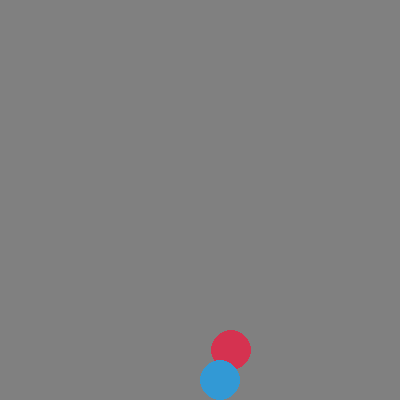

In [23]:
import pygame

pygame.init()
screen = pygame.display.set_mode((400, 400))
DATA_DIR = '/content/drive/MyDrive/cs664/hit_ball/data'
MODEL_PATH = os.path.join(DATA_DIR, "ball_hit_ball_model_t5.keras")
BATCH_SIZE = 32
NUM_EPOCHS = 4

# 载入模型，当模型在不同版本的keras下训练时，可将compile设置为False
model = load_model(MODEL_PATH, compile=False)
model.compile(optimizer=Adam(learning_rate=1e-6), loss="mse")

# 启动游戏
game = auto_game.Ball_Hit_Ball_Game()

# 初始化变量
num_games, num_wins = 0, 0

for e in range(NUM_EPOCHS):
    game.reset()
    a_t = 0  # 选择第一个动作
    x_0, r_0, game_over = game.step(a_t) # 执行第一个动作
    s_t = preprocess_images(x_0)    # 数据处理
    img_bgr = cv2.cvtColor(x_0.transpose([1, 0, 2]), cv2.COLOR_RGB2BGR)

    #Display image, clear cell every 0.5 seconds
    output.clear()
    cv2_imshow(img_bgr)
    time.sleep(0.2)
    while (a_t ==0) and (not game_over):
        s_tm1 = s_t  # 保存为t-1时刻的截屏


        q = model.predict(s_t,verbose=0)[0]
        a_t = int(q>0.5)
        x_t, r_t, game_over = game.step(a_t)  # 执行动作，获取反馈
        s_t = preprocess_images(x_t)  # 对数据进行处理
        img_bgr = cv2.cvtColor(x_t.transpose([1, 0, 2]), cv2.COLOR_RGB2BGR)
        output.clear()
        cv2_imshow(img_bgr)
        time.sleep(0.2)

    while (a_t==1) and (not game_over):
        x_t, r_t, game_over = game.step(a_t)  # 执行动作，获取反馈
        s_t = preprocess_images(x_t)
        img_bgr = cv2.cvtColor(x_t.transpose([1, 0, 2]), cv2.COLOR_RGB2BGR)
        output.clear()
        cv2_imshow(img_bgr)
        time.sleep(0.2)
    time.sleep(2)
    if r_t == 1:  # 如果篮球碰到红球，记录成功一次
        num_wins += 1
    num_games += 1
pygame.quit() # 退出游戏
